# 🧠 Multi-Task Brain Tumor Model (Classification + Segmentation)
Using Figshare Brain MRI Dataset in Google Colab

## 📦 Step 1: Install Required Libraries

In [1]:

!pip install -q scipy imageio h5py matplotlib opencv-python keras-tuner tf-keras-vis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.7 MB/s eta 0:00:00


## 🔗 Step 2: Mount Google Drive and Set Dataset Path

In [2]:

from google.colab import drive
drive.mount('/content/drive')

# Set dataset path
dataset_path = '/content/drive/MyDrive/figshare_dataset'


Mounted at /content/drive


In [4]:
!cp -r /content/drive/MyDrive/final_dataset_by_class /content/


In [ ]:
!cp -r /content/drive/MyDrive/figshare_dataset /content/

## 📂 Step 3: Load PNG Images and Masks from Final Dataset

In [ ]:

import os
import scipy.io
import h5py
import imageio
import numpy as np

input_root = '/content/figshare_dataset'  # Your folder with 4 subfolders
output_root = '/content/final_dataset_by_class'
label_map = {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}

# Create output directories
for class_name in label_map.values():
    os.makedirs(os.path.join(output_root, class_name, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_root, class_name, 'masks'), exist_ok=True)

count = 0
for subfolder in ['folder 1', 'folder 2', 'folder 3', 'folder 4']:
    folder_path = os.path.join(input_root, subfolder)
    for file in os.listdir(folder_path):
        if file.endswith('.mat'):
            mat_path = os.path.join(folder_path, file)
            try:
                data = scipy.io.loadmat(mat_path)
                img = data['cjdata']['image'][0][0]
                label = int(data['cjdata']['label'][0][0][0][0])
                mask = data['cjdata']['tumorMask'][0][0]
            except:
                with h5py.File(mat_path, 'r') as f:
                    img = np.array(f['cjdata']['image']).T
                    label = int(np.array(f['cjdata']['label'])[0][0])
                    mask = np.array(f['cjdata']['tumorMask']).T

            class_name = label_map[label]
            img_path = os.path.join(output_root, class_name, 'images', f'image_{count:04d}.png')
            mask_path = os.path.join(output_root, class_name, 'masks', f'image_{count:04d}_mask.png')

            imageio.imwrite(img_path, img.astype(np.uint8))
            imageio.imwrite(mask_path, mask.astype(np.uint8))
            count += 1

            if count % 200 == 0:
                print(f"✅ Processed {count} files.")

print("🎉 All files converted and organized by class.")



✅ Processed 200 files.
✅ Processed 400 files.
✅ Processed 600 files.
✅ Processed 800 files.
✅ Processed 1000 files.
✅ Processed 1200 files.
✅ Processed 1400 files.
✅ Processed 1600 files.
✅ Processed 1800 files.
✅ Processed 2000 files.
✅ Processed 2200 files.
✅ Processed 2400 files.
✅ Processed 2600 files.
✅ Processed 2800 files.
✅ Processed 3000 files.
🎉 All files converted and organized by class.


In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Folder containing the class folders: meningioma, glioma, pituitary
dataset_path = '/content/final_dataset_by_class'
label_map = {'meningioma': 0, 'glioma': 1, 'pituitary': 2}

images, labels, masks = [], [], []

for class_name, label in label_map.items():
    folder_path = os.path.join(dataset_path, class_name, 'images')  # assumes images in /images
    mask_path = os.path.join(dataset_path, class_name, 'masks')     # assumes masks in /masks

    for file in os.listdir(folder_path):
        if file.endswith('.png') and '_mask' not in file:
            img_file = os.path.join(folder_path, file)
            mask_file = os.path.join(mask_path, file.replace('.png', '_mask.png'))

            if os.path.exists(img_file) and os.path.exists(mask_file):
                img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

                if img is not None and mask is not None:
                    img = cv2.resize(img, (224, 224))
                    mask = cv2.resize(mask, (224, 224))

                    images.append(img)
                    masks.append(mask)
                    labels.append(label)

# Convert to NumPy arrays
images = np.expand_dims(np.array(images, dtype='float32') / 255.0, axis=-1)
masks = np.expand_dims(np.array(masks, dtype='float32') / 255.0, axis=-1)
labels = to_categorical(np.array(labels), num_classes=3)

print(f"✅ Loaded {len(images)} image-mask pairs.")



✅ Loaded 3064 image-mask pairs.


## 🧪 Step 4: Split Dataset into Train/Val

In [6]:

from sklearn.model_selection import train_test_split

X_train, X_val, y_cls_train, y_cls_val, y_seg_train, y_seg_val = train_test_split(
    images, labels, masks, test_size=0.2, random_state=42
)


In [21]:
unique, counts = np.unique(np.argmax(y_cls_train, axis=1), return_counts=True)
print(dict(zip(['Meningioma', 'Glioma', 'Pituitary'], counts)))

{'Meningioma': np.int64(548), 'Glioma': np.int64(1150), 'Pituitary': np.int64(753)}


## 🧠 Step 5: Build Multi-Task Model with Keras Functional API

In [15]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import ResNet50

def build_multitask_model(input_shape=(224, 224, 1)):
    inp = Input(shape=input_shape, name="input_image")

    # Convert grayscale to 3-channel manually
    x = layers.Concatenate()([inp, inp, inp])  # (224, 224, 3)

    # Load ResNet base (do NOT use input_tensor!)
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base.trainable = False
    features = base(x)

    # Classification head
    cls = layers.GlobalAveragePooling2D()(features)
    cls = layers.Dense(64, activation='relu')(cls)
    cls_out = layers.Dense(3, activation='softmax', name='classification')(cls)

    # Segmentation head (upsample to 224x224)
    seg = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(features)  # 7 → 14
    seg = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(seg)       # 14 → 28
    seg = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(seg)        # 28 → 56
    seg = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(seg)        # 56 → 112
    seg = layers.Conv2DTranspose(16, 3, strides=2, padding='same')(seg)        # 112 → 224
    seg_out = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(seg)


    model = Model(inputs=inp, outputs=[cls_out, seg_out])
    return model






In [16]:
# ✅ Build and compile
model = build_multitask_model()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [17]:
#model.compile(
    optimizer='adam',
    loss={'classification': 'categorical_crossentropy', 'segmentation': 'binary_crossentropy'},
    metrics={'classification': 'accuracy', 'segmentation': 'accuracy'}
)




In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'classification': weighted_categorical_crossentropy(class_weights),
        'segmentation': 'binary_crossentropy'
    },
    metrics={
        'classification': 'accuracy',
        'segmentation': tf.keras.metrics.MeanIoU(num_classes=2)
    }
)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping
# ✅ Early stopping callback
early_stop = EarlyStopping(
    monitor='val_segmentation_accuracy',
    patience=4,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

## 🚀 Step 6: Train the Model

In [24]:
import tensorflow as tf

def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        loss = y_true * tf.math.log(y_pred) * weights
        return -tf.reduce_sum(loss, axis=-1)

    return loss_fn


In [25]:
# Sample counts (from you)
class_counts = np.array([548, 1150, 753])
total = np.sum(class_counts)
class_weights = total / (3 * class_counts)  # Balanced weight formula

print("Custom weights:", class_weights)



Custom weights: [1.49087591 0.71043478 1.08499336]


In [27]:
# ✅ Fit model
history = model.fit(
    X_train,
    {'classification': y_cls_train, 'segmentation': y_seg_train},
    validation_data=(X_val, {'classification': y_cls_val, 'segmentation': y_seg_val}),
    epochs=30,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 51s 201ms/step - classification_accuracy: 0.6291 - classification_loss: 0.8942 - loss: 0.8949 - segmentation_loss: 7.6652e-04 - segmentation_mean_io_u: 1.0000 - val_classification_accuracy: 0.6786 - val_classification_loss: 0.8887 - val_loss: 0.8851 - val_segmentation_loss: 6.9405e-04 - val_segmentation_mean_io_u: 1.0000
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_segmentation_accuracy` which is not available. Available metrics are: classification_accuracy,classification_loss,loss,segmentation_loss,segmentation_mean_io_u,val_classification_accuracy,val_classification_loss,val_loss,val_segmentation_loss,val_segmentation_mean_io_u
  current = self.get_monitor_value(logs)


154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - classification_accuracy: 0.6536 - classification_loss: 0.8529 - loss: 0.8536 - segmentation_loss: 6.6489e-04 - segmentation_mean_io_u: 1.0000 - val_classification_accuracy: 0.6721 - val_classification_loss: 0.8711 - val_loss: 0.8676 - val_segmentation_loss: 6.3997e-04 - val_segmentation_mean_io_u: 1.0000
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - classification_accuracy: 0.6589 - classification_loss: 0.8320 - loss: 0.8327 - segmentation_loss: 6.3060e-04 - segmentation_mean_io_u: 1.0000 - val_classification_accuracy: 0.6803 - val_classification_loss: 0.8529 - val_loss: 0.8494 - val_segmentation_loss: 6.2573e-04 - val_segmentation_mean_io_u: 1.0000
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - classification_accuracy: 0.6698 - classification_loss: 0.8264 - loss: 0.8270 - segmentation_loss: 6.2789e-04 - segmentation_mean_io_u: 1.0000 - val_classification_accuracy: 0.6688 - val_classification_loss: 0.8439 - val_loss: 0.840

In [ ]:
model.save('/content/drive/MyDrive/multitask_brain_model.h5')


In [ ]:
model.save('/content/drive/MyDrive/multitask_brain_model.keras')


In [29]:
from tensorflow.keras.models import load_model

# Replace with your actual path
model_path = '/content/drive/MyDrive/multitask_brain_model.keras'

model = load_model(model_path, compile=False)

## 📊 Step 7: Evaluate and Visualize Predictions

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step
📋 Classification Report:
              precision    recall  f1-score   support

  Meningioma       0.60      0.78      0.67       160
      Glioma       0.80      0.72      0.76       276
   Pituitary       0.90      0.79      0.84       177

    accuracy                           0.76       613
   macro avg       0.77      0.76      0.76       613
weighted avg       0.78      0.76      0.76       613

🎯 Classification Accuracy: 0.7569


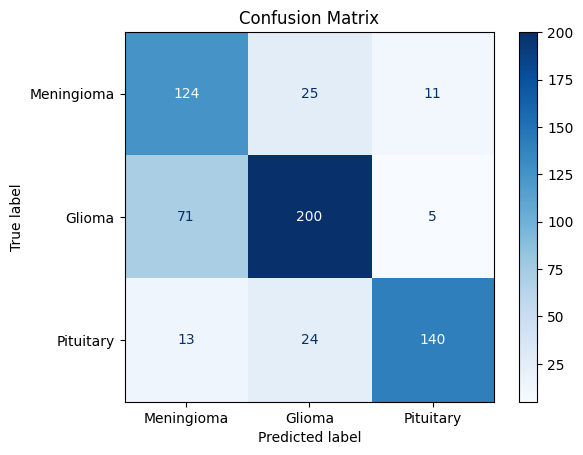

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 📊 Predict class labels
y_pred_cls = np.argmax(model.predict(X_val)[0], axis=1)
y_true_cls = np.argmax(y_cls_val, axis=1)

# 🧾 Classification Report
print("📋 Classification Report:")
print(classification_report(y_true_cls, y_pred_cls, target_names=['Meningioma', 'Glioma', 'Pituitary']))

# ✅ Accuracy Score
accuracy = accuracy_score(y_true_cls, y_pred_cls)
print(f"🎯 Classification Accuracy: {accuracy:.4f}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Meningioma', 'Glioma', 'Pituitary'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_multitask_predictions(X_val, y_cls_val, y_seg_val, model, class_names=None, num_samples=5):
    indices = np.random.choice(len(X_val), size=num_samples, replace=False)

    for idx in indices:
        # Get predictions (multi-output model)
        cls_pred, seg_pred = model.predict(X_val[idx:idx+1])
        pred_class = np.argmax(cls_pred[0])
        pred_mask = seg_pred[0, :, :, 0]
        true_mask = y_seg_val[idx, :, :, 0]

        plt.figure(figsize=(14, 4))

        # Input image
        plt.subplot(1, 4, 1)
        plt.imshow(X_val[idx].squeeze(), cmap='gray')
        plt.title("Input MRI")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 4, 3)
        plt.imshow(pred_mask, cmap='jet')
        plt.title("Predicted Mask")
        plt.axis('off')

        # Class prediction
        plt.subplot(1, 4, 4)
        label = class_names[pred_class] if class_names else f"Class {pred_class}"
        plt.text(0.1, 0.5, f"Predicted:\n{label}", fontsize=14)
        plt.axis('off')

        plt.tight_layout()
        plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


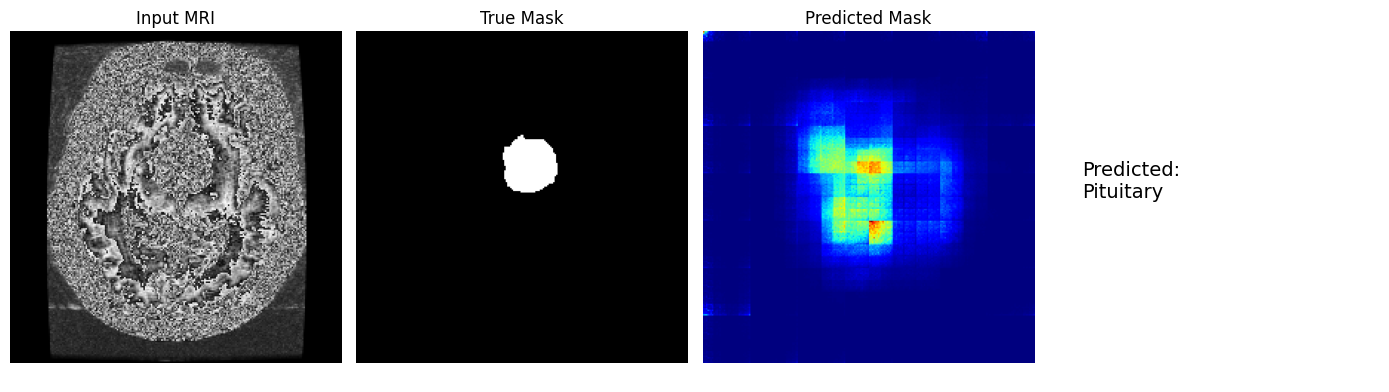

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


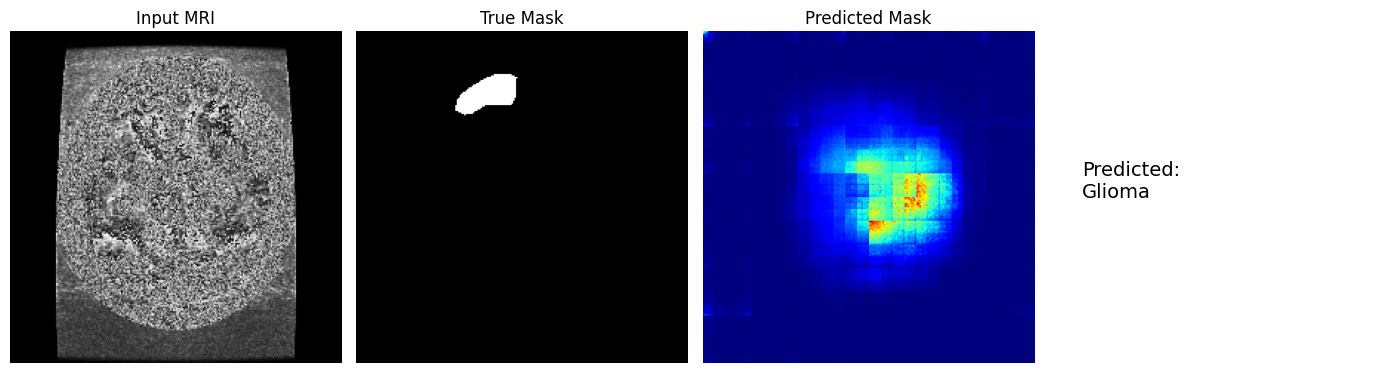

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


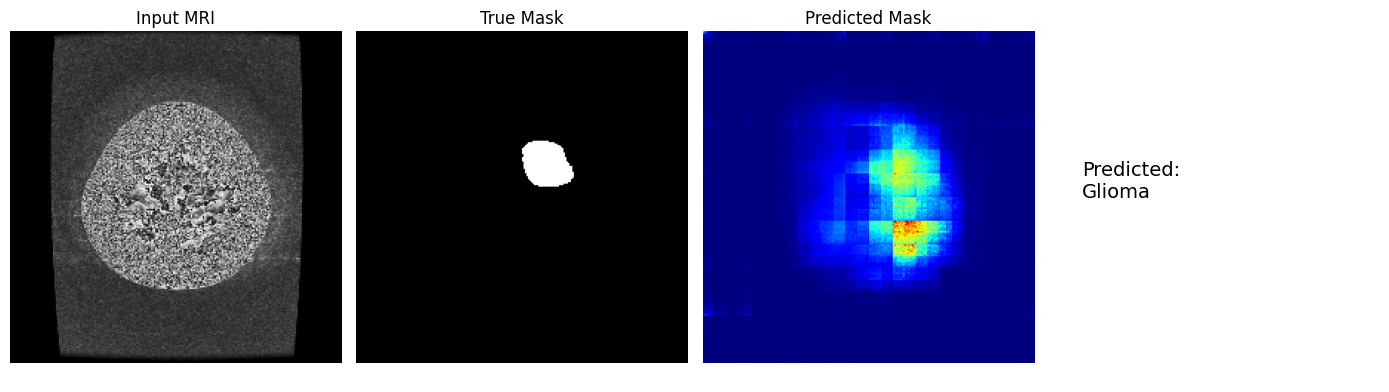

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


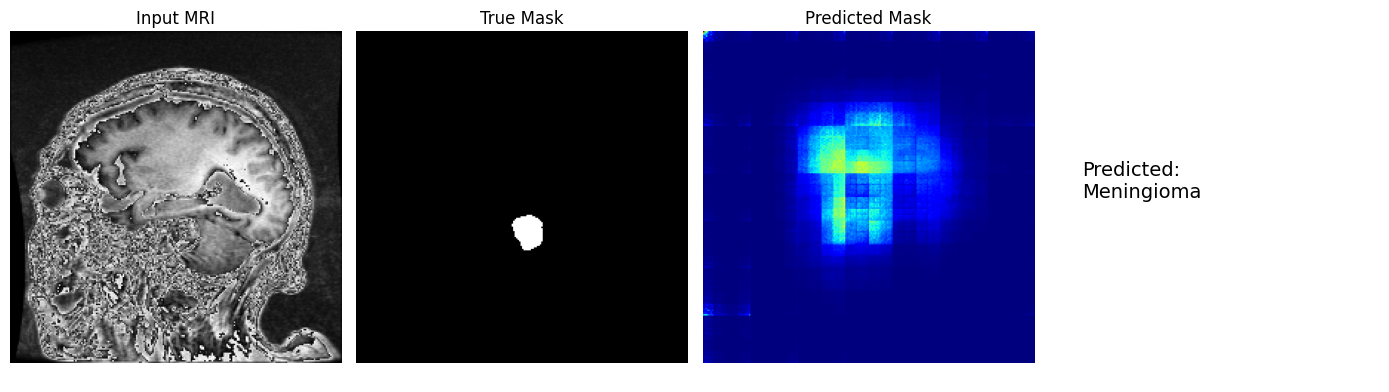

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


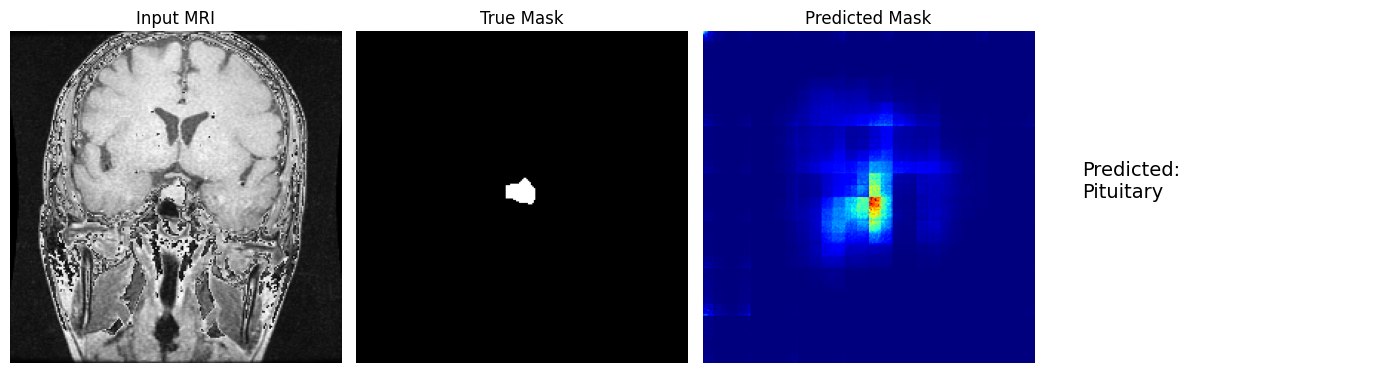

In [ ]:
class_names = ['Meningioma', 'Glioma', 'Pituitary']
visualize_multitask_predictions(X_val, y_cls_val, y_seg_val, model, class_names=class_names, num_samples=5)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


<ipython-input-31-8cc2e87c535b>:31: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


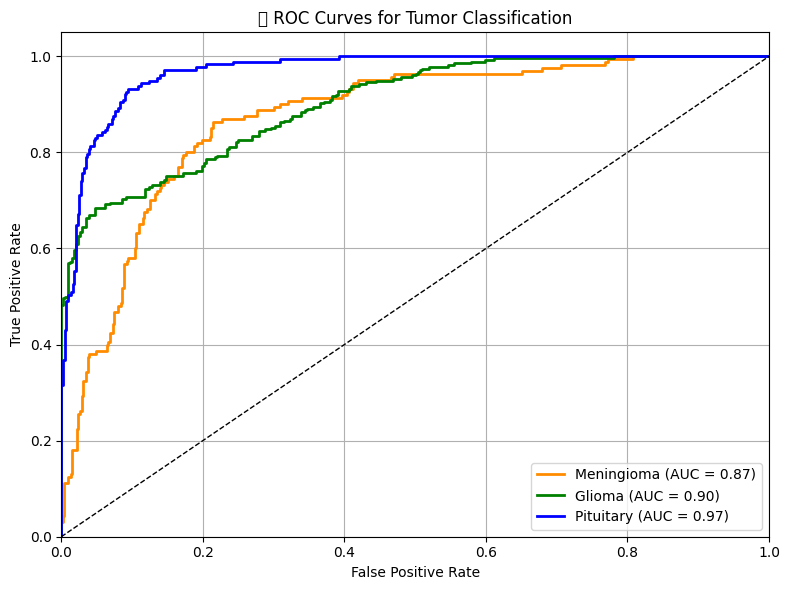

In [31]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict class probabilities
y_probs = model.predict(X_val)[0]
y_true_bin = y_cls_val  # should be one-hot encoded

# Compute ROC curves and AUC
fpr, tpr, roc_auc = {}, {}, {}
labels = ['Meningioma', 'Glioma', 'Pituitary']

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🔍 ROC Curves for Tumor Classification")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Improvising Segmentation module

In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)




In [33]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K

# Dice loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss
def dice_bce_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

# Build model
# ✅ Revert back to previous version without encoder renaming

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K

# Dice loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss
def dice_bce_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

# Build model with EfficientNetB0
def build_custom_unet(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    skip1 = base_model.get_layer('block2a_activation').output  # 56x56
    skip2 = base_model.get_layer('block3a_activation').output  # 28x28
    skip3 = base_model.get_layer('block4a_activation').output  # 14x14
    encoder_output = base_model.output                          # 7x7

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(encoder_output)
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(1e-4),
        loss=dice_bce_loss,
        metrics=['accuracy', MeanIoU(num_classes=2)]
    )
    return model

# Build and compile the model
custom_unet = build_custom_unet()





16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [34]:
history = custom_unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=20
)


Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 95s 360ms/step - accuracy: 0.9551 - loss: 1.1124 - mean_io_u_1: 1.0000 - val_accuracy: 0.9832 - val_loss: 1.0006 - val_mean_io_u_1: 1.0000
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.9830 - loss: 1.0004 - mean_io_u_1: 1.0000 - val_accuracy: 0.9832 - val_loss: 1.0002 - val_mean_io_u_1: 1.0000
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.9830 - loss: 1.0001 - mean_io_u_1: 1.0000 - val_accuracy: 0.9832 - val_loss: 1.0000 - val_mean_io_u_1: 1.0000
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.9830 - loss: 1.0001 - mean_io_u_1: 1.0000 - val_accuracy: 0.9832 - val_loss: 1.0000 - val_mean_io_u_1: 1.0000
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9833 - loss: 1.0001 - mean_io_u_1: 1.0000 - val_accuracy: 0.9832 - val_loss: 1.0000 - val_mean_io_u_1: 1.0000
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.9836 - loss: 1.0001 - mean_io_u_1: 1.000

In [ ]:
model.save('/content/drive/MyDrive/segmentation_brain_model.keras')

In [ ]:
results = custom_unet.evaluate(X_val, y_val, verbose=1)
print(f"\n🔍 Evaluation Results:\nLoss: {results[0]:.4f} | Accuracy: {results[1]:.4f} | MeanIoU: {results[2]:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9829 - loss: 0.9998 - mean_io_u_6: 1.0000

🔍 Evaluation Results:
Loss: 0.9998 | Accuracy: 0.9831 | MeanIoU: 1.0000


In [35]:
y_pred = custom_unet.predict(X_val)
y_pred_thresh = (y_pred > 0.1).astype("float32")  # binarize output


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 737ms/step


In [36]:
import matplotlib.pyplot as plt

def display_sample(i):
    plt.figure(figsize=(10, 4))

    # Original MRI
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title("Input Image")
    plt.axis("off")

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_thresh[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


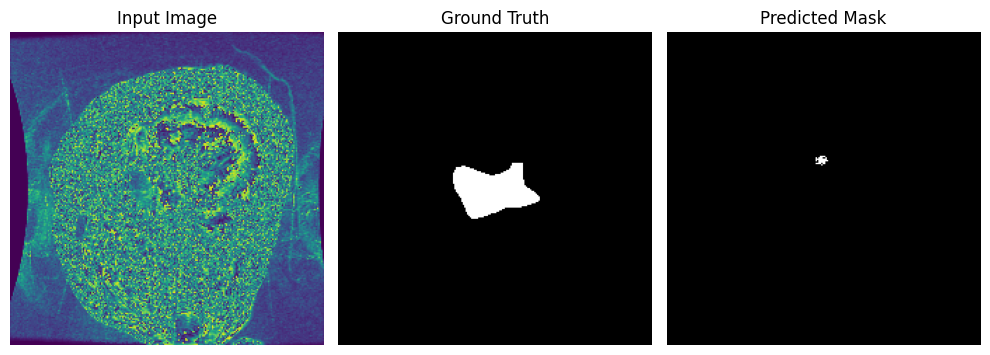

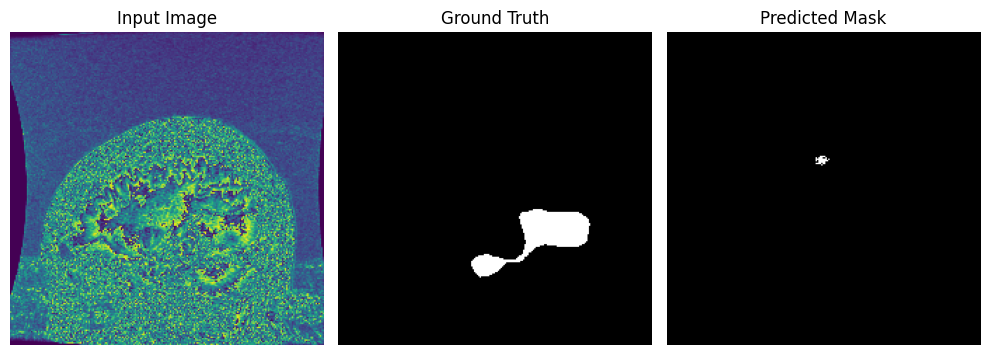

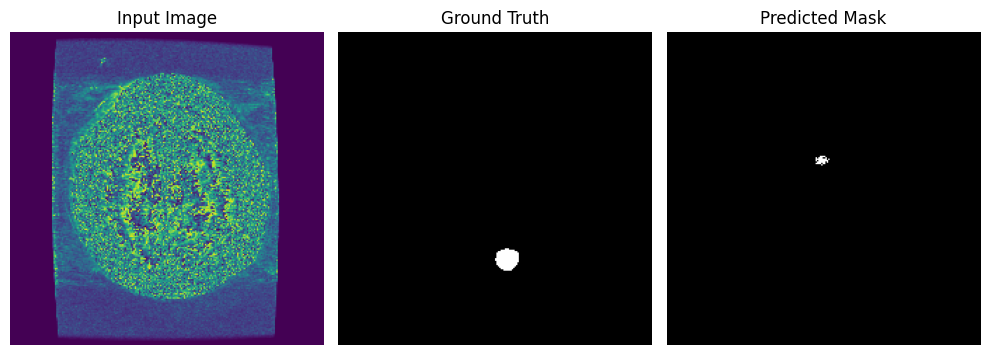

In [37]:
display_sample(20)
display_sample(50)
display_sample(25)
